#Packages/Installations

In [1]:
!pip3 install nest_asyncio
!python3 -m pip install pystan
!python -m pip install Cython
!pip install nfl_data_py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import nfl_data_py as nfl
import nest_asyncio
import stan

#Best Ball Mania Data

In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/bbm_data.csv'
data = pd.read_csv(file_path, index_col=[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = data[['draft_id', 'player_name', 'position_name', 'position_pick_number', 'year']]
data

,draft_id,player_name,position_name,position_pick_number,year
0,65219f4a-267e-4035-806a-646a3c1a846e,Stefon Diggs,WR,4,2023
1,65219f4a-267e-4035-806a-646a3c1a846e,Josh Allen,QB,1,2023
2,65219f4a-267e-4035-806a-646a3c1a846e,Keenan Allen,WR,16,2023
3,65219f4a-267e-4035-806a-646a3c1a846e,Christian Watson,WR,23,2023
4,65219f4a-267e-4035-806a-646a3c1a846e,T.J. Hockenson,TE,3,2023
...,...,...,...,...,...
22434313,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Kareem Hunt,RB,25,2021
22434314,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Amari Cooper,WR,11,2021
22434315,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Austin Hooper,TE,24,2021
22434316,ffff3a71-d0bb-491d-bce0-635aa2242d9f,D.J. Chark,WR,34,2021


In [56]:
jt = data[(data['player_name'] == 'Dalvin Cook') & (data['year'] == 2023)]
position_counts = jt['position_pick_number'].value_counts().sort_index()

# Plot the counts as a bar plot
plt.figure(figsize=(10, 6))
position_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Position Pick Number')
plt.ylabel('Frequency')
plt.title('Count of Position Pick Number for Jonathan Taylor in 2023')
plt.show()

KeyError: 'position_pick_number'

#Fantasy Points Data (NFL Data Py)

In [6]:
print([i for i in nfl.see_pbp_cols()])

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

In [7]:
nfl_data = nfl.import_weekly_data([2021, 2022, 2023], columns = ['player_display_name', 'position', 'season', 'week', 'fantasy_points', 'fantasy_points_ppr'])
nfl_data['fantasy_points_half_ppr'] = ((nfl_data['fantasy_points'] + nfl_data['fantasy_points_ppr']) / 2)
nfl_data['fantasy_points_half_ppr'] = nfl_data['fantasy_points_half_ppr']
nfl_data.drop(columns=['fantasy_points', 'fantasy_points_ppr'], inplace=True)
nfl_data

Downcasting floats.


,player_display_name,position,season,week,fantasy_points_half_ppr
0,Tom Brady,QB,2021,1,27.160000
1,Tom Brady,QB,2021,2,29.639999
2,Tom Brady,QB,2021,3,28.680000
3,Tom Brady,QB,2021,4,11.060000
4,Tom Brady,QB,2021,5,37.740002
...,...,...,...,...,...
5648,Zach Charbonnet,RB,2023,14,5.300000
5649,Zach Charbonnet,RB,2023,15,1.600000
5650,Zach Charbonnet,RB,2023,16,0.100000
5651,Zach Charbonnet,RB,2023,17,6.600000


#Fitting STAN Model

In [7]:
nest_asyncio.apply()

In [8]:
mean_fantasy_points_by_year = nfl_data.groupby(['player_display_name', 'season'])['fantasy_points_half_ppr'].mean().reset_index()
mean_position_pick_number_by_year = data.groupby(['player_name', 'year', 'position_name'])['position_pick_number'].mean().reset_index()

merged_data_by_year = mean_fantasy_points_by_year.merge(
    mean_position_pick_number_by_year,
    left_on=['player_display_name', 'season'],
    right_on=['player_name', 'year'],
    how='inner'
).drop(columns=['player_name', 'season'])

In [9]:
merged_data_by_year

,player_display_name,fantasy_points_half_ppr,year,position_name,position_pick_number
0,A.J. Brown,12.292857,2021,WR,6.687597
1,A.J. Brown,14.135000,2022,WR,10.732179
2,A.J. Brown,13.917647,2023,WR,6.100004
3,A.J. Green,7.635294,2021,WR,75.090923
4,A.J. Green,3.815384,2022,WR,83.498659
...,...,...,...,...,...
1384,Zay Jones,6.062500,2021,WR,96.500000
1385,Zay Jones,10.294445,2022,WR,82.752882
1386,Zay Jones,6.788889,2023,WR,56.383503
1387,Zonovan Knight,7.500000,2022,RB,58.250000


In [10]:
mean_fantasy_points_by_year

,player_display_name,season,fantasy_points_half_ppr
0,A.J. Brown,2021,12.292857
1,A.J. Brown,2022,14.135000
2,A.J. Brown,2023,13.917647
3,A.J. Dillon,2021,9.838888
4,A.J. Dillon,2022,9.035295
...,...,...,...
1867,Zay Jones,2021,6.062500
1868,Zay Jones,2022,10.294445
1869,Zay Jones,2023,6.788889
1870,Zonovan Knight,2022,7.500000


In [11]:
merged_data_by_year

,player_display_name,fantasy_points_half_ppr,year,position_name,position_pick_number
0,A.J. Brown,12.292857,2021,WR,6.687597
1,A.J. Brown,14.135000,2022,WR,10.732179
2,A.J. Brown,13.917647,2023,WR,6.100004
3,A.J. Green,7.635294,2021,WR,75.090923
4,A.J. Green,3.815384,2022,WR,83.498659
...,...,...,...,...,...
1384,Zay Jones,6.062500,2021,WR,96.500000
1385,Zay Jones,10.294445,2022,WR,82.752882
1386,Zay Jones,6.788889,2023,WR,56.383503
1387,Zonovan Knight,7.500000,2022,RB,58.250000


In [12]:
df_wr = merged_data_by_year[merged_data_by_year['position_name'] == 'WR']

stan_data = {
    'N': len(df_wr),
    'position_pick_number': df_wr['position_pick_number'].values,
    'fantasy_points_half_ppr': df_wr['fantasy_points_half_ppr'].values
}

In [17]:
stan_code = """
data {
  int<lower=0> N; // Number of data points
  vector[N] position_pick_number; // Predictor
  vector[N] fantasy_points_half_ppr; // Response
}

parameters {
  real alpha; // Intercept
  real beta1; // Linear term
  real beta2; // Quadratic term
  real sigma_alpha;
  real sigma_beta1;
  // real<lower=0> sigma Standard deviation of the residuals
}

model {
  // Priors
  alpha ~ normal(0, 10);
  sigma_alpha ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  sigma_alpha ~ normal(0, 10);
  beta2 ~ normal(0, 10);

  // Likelihood
  fantasy_points_half_ppr ~ normal(alpha + beta1 * position_pick_number + beta2 * square(position_pick_number), sigma_alpha + sigma_beta1 * position_pick_number);
}
"""

# Compile the model
model = stan.build(stan_code, data=stan_data)

# Sample from the posterior
fit = model.sample(num_chains=4, num_samples=1000)

Building...



Building: 45.9s, done.Messages from stanc:
Warning in '/tmp/httpstan_09c94pti/model_qjoqhukn.stan', line 20, column 2: The
    parameter sigma_alpha is on the left-hand side of more than one tilde
    statement.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1701/8000)
Sampling:  23% (1801/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2301/8000)


In [21]:
fit_df = fit.to_frame()
print(fit_df.describe())

parameters         lp__  accept_stat__   stepsize__  treedepth__  \
count       4000.000000    4000.000000  4000.000000  4000.000000   
mean        -824.444548       0.931982     0.006218     7.682250   
std            1.545787       0.093727     0.000169     1.425936   
min         -833.299486       0.310295     0.006017     1.000000   
25%         -825.229361       0.905221     0.006107     7.000000   
50%         -824.113479       0.972324     0.006188     8.000000   
75%         -823.302964       0.995630     0.006300     9.000000   
max         -822.095856       1.000000     0.006477    10.000000   

parameters  n_leapfrog__  divergent__     energy__        alpha        beta1  \
count        4000.000000       4000.0  4000.000000  4000.000000  4000.000000   
mean          393.634500          0.0   826.958709    14.815847    -0.176554   
std           276.483886          0.0     2.259527     0.520812     0.022464   
min             1.000000          0.0   822.388330    12.913150    

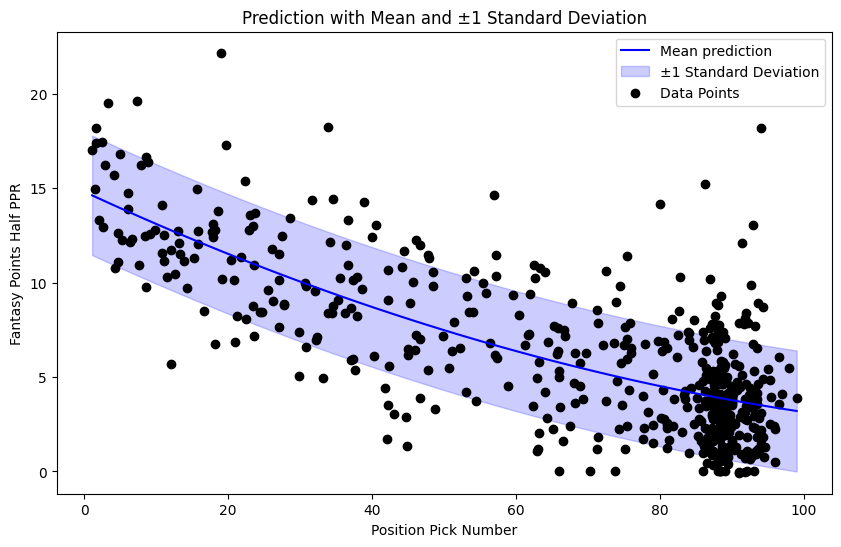

In [25]:
posterior_samples = fit.to_frame()
alpha_samples = posterior_samples['alpha']
beta1_samples = posterior_samples['beta1']
beta2_samples = posterior_samples['beta2']
sigma_alpha_samples = posterior_samples['sigma_alpha']
sigma_beta1_samples = posterior_samples['sigma_beta1']

# Calculate the mean and standard deviation of the parameters
alpha_mean = np.mean(alpha_samples)
beta1_mean = np.mean(beta1_samples)
beta2_mean = np.mean(beta2_samples)
sigma_alpha_mean = np.mean(sigma_alpha_samples)
sigma_beta1_mean = np.mean(sigma_beta1_samples)

# Define the position pick number range for the plot
x = np.linspace(min(stan_data['position_pick_number']), max(stan_data['position_pick_number']), 100)

# Calculate the mean predicted values
y_mean = alpha_mean + beta1_mean * x + beta2_mean * np.square(x)

# Calculate the standard deviation of the predictions
y_std = np.sqrt(sigma_alpha_mean**2 + (sigma_beta1_mean * x)**2)

# Plot the mean and ±1 standard deviation
plt.figure(figsize=(10, 6))
plt.plot(x, y_mean, label='Mean prediction', color='blue')
plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='±1 Standard Deviation')
plt.scatter(stan_data['position_pick_number'], stan_data['fantasy_points_half_ppr'], color='black', label='Data Points')
plt.xlabel('Position Pick Number')
plt.ylabel('Fantasy Points Half PPR')
plt.title('Prediction with Mean and ±1 Standard Deviation')
plt.legend()
plt.show()

#Second Model

In [8]:
nest_asyncio.apply()
data['avg_draft_position'] = data.groupby(['year', 'player_name'])['position_pick_number'].transform('mean')
data = data[['player_name', 'position_name', 'year', 'avg_draft_position']].drop_duplicates()
merged_data = pd.merge(nfl_data, data, how='inner',
                       left_on=['player_display_name', 'position', 'season'],
                       right_on=['player_name', 'position_name', 'year'])

merged_data = merged_data[['player_display_name', 'position', 'season', 'week', 'fantasy_points_half_ppr', 'avg_draft_position']]

In [9]:
merged_data['player_year_id'] = pd.factorize(merged_data['player_display_name'].astype(str) + '_' + merged_data['season'].astype(str))[0] + 1  # Ensure 1-indexing for Stan

In [10]:
merged_data = merged_data[merged_data['position'] == 'WR']

In [11]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id
72,Danny Amendola,WR,2021,1,11.900000,88.000000,7
73,Danny Amendola,WR,2021,2,1.400000,88.000000,7
74,Danny Amendola,WR,2021,7,3.200000,88.000000,7
75,Danny Amendola,WR,2021,8,1.300000,88.000000,7
76,Danny Amendola,WR,2021,9,6.400000,88.000000,7
...,...,...,...,...,...,...,...
14654,Jayden Reed,WR,2023,15,14.200001,72.504599,1373
14655,Jayden Reed,WR,2023,17,23.900000,72.504599,1373
14656,Jayden Reed,WR,2023,18,13.200000,72.504599,1373
14657,Jayden Reed,WR,2023,19,0.000000,72.504599,1373


In [12]:
merged_data['player_year_id'] = merged_data.groupby(['player_display_name', 'season']).ngroup() + 1


In [13]:
max(merged_data['player_year_id'])

533

In [14]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position,player_year_id
72,Danny Amendola,WR,2021,1,11.900000,88.000000,120
73,Danny Amendola,WR,2021,2,1.400000,88.000000,120
74,Danny Amendola,WR,2021,7,3.200000,88.000000,120
75,Danny Amendola,WR,2021,8,1.300000,88.000000,120
76,Danny Amendola,WR,2021,9,6.400000,88.000000,120
...,...,...,...,...,...,...,...
14654,Jayden Reed,WR,2023,15,14.200001,72.504599,264
14655,Jayden Reed,WR,2023,17,23.900000,72.504599,264
14656,Jayden Reed,WR,2023,18,13.200000,72.504599,264
14657,Jayden Reed,WR,2023,19,0.000000,72.504599,264


In [15]:
min(merged_data['player_year_id'])

1

In [16]:
import stan

In [17]:
stan_model_code = """
data {
  int<lower=0> N;  // number of data points
  int<lower=0> K;  // number of wide receivers
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector[K] alpha;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model
  real beta1;  // linear coefficient for the quadratic model
  real beta2;  // quadratic coefficient for the quadratic model
  real<lower=0> sigma;  // standard deviation of the weekly scores
  real<lower=0> tau;  // standard deviation of the alpha's
}

model {
  vector[K] mu;

  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  tau ~ normal(0, 5);
  sigma ~ normal(0, 5);

  // Quadratic model for the means
  for (k in 1:K) {
    mu[k] = beta0 + beta1 * adp[k] + beta2 * adp[k] * adp[k];
  }

  // Hierarchical model for alpha
  alpha ~ normal(mu, tau);

  // Likelihood
  for (n in 1:N) {
    weekly_score[n] ~ normal(alpha[receiver[n]], sigma);
  }
}
"""

In [33]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector[K] alpha;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model
  real beta1;  // linear coefficient for the quadratic model
  real beta2;  // quadratic coefficient for the quadratic model
  real<lower=0> sigma;  // standard deviation of the weekly scores
  real<lower=0> tau;  // standard deviation of the alpha's
}

transformed parameters {
  vector[K] mu; // overall mean of alphas
  for (k in 1:K) {
    mu[k] = beta0 + beta1 * adp[k] + beta2 * adp[k] * adp[k];
  }
}

model {
  // likelihood
  for (n in 1:N) {
    weekly_score[n] ~ normal(alpha[receiver[n]], sigma);
  }
  //
  alpha ~ normal(mu, tau);

  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  tau ~ normal(0, 10);
  sigma ~ normal(0, 10);
}
"""

In [34]:
def prepare_stan_data(df):
    # Ensure the player_year_id column is unique per player and season
    df['receiver_index'] = df['player_year_id'].astype('category').cat.codes + 1
    N = df.shape[0]
    K = df['receiver_index'].nunique()
    receiver = df['receiver_index'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['receiver_index', 'avg_draft_position']].sort_values('receiver_index')['avg_draft_position'].values

    stan_data = {
        'N': N,
        'K': K,
        'receiver': receiver.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist()
    }

    return stan_data

# Prepare the data
stan_data = prepare_stan_data(merged_data)

# Compile the Stan model
stan_model = stan.build(stan_model_code, data=stan_data)

# Fit the Stan model
fit = stan_model.sample(num_chains=1, num_samples=10)
#fit = stan_model.sample(num_chains=4, num_samples=2000)

# Print the summary of the fit
print(fit)

# Extract the samples for further analysis
samples = fit.to_frame()

# For example, to get the posterior means of beta coefficients
beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

print(f'Posterior means of beta coefficients: beta0 = {beta0_mean}, beta1 = {beta1_mean}, beta2 = {beta2_mean}')

Building...



Building: 57.8s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1010)
Sampling:  10% (100/1010)
Sampling:  20% (200/1010)
Sampling:  30% (300/1010)
Sampling:  40% (400/1010)
Sampling:  50% (500/1010)
Sampling:  59% (600/1010)
Sampling:  69% (700/1010)
Sampling:  79% (800/1010)
Sampling:  89% (900/1010)
Sampling:  99% (1000/1010)
Sampling:  99% (1001/1010)
Sampling: 100% (1010/1010)
Sampling: 100% (1010/1010), done.
Messages received during sampling:
  Gradient evaluation took 0.001678 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.78 seconds.
  Adjust your expectations accordingly!


<stan.Fit>
Parameters:
    alpha: (533,)
    beta0: ()
    beta1: ()
    beta2: ()
    sigma: ()
    tau: ()
    mu: (533,)
Draws: 10
Posterior means of beta coefficients: beta0 = 10.368617470357965, beta1 = -0.15227182939774916, beta2 = 0.0006782418157608297


In [44]:
samples

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,alpha.3,...,mu.524,mu.525,mu.526,mu.527,mu.528,mu.529,mu.530,mu.531,mu.532,mu.533
draws,,,,,,,,,,,,,,,,,,,,,
0,-15359.158354,0.984497,0.004412,10.0,1023.0,0.0,15771.015940,11.353193,5.388575,9.593682,...,2.068840,2.094745,2.055107,1.953755,1.987562,2.083720,4.773475,1.807844,2.220788,3.651830
1,-15344.701754,0.954996,0.004412,10.0,1023.0,0.0,15625.610445,11.031086,5.751995,9.568801,...,1.795325,1.847122,1.767340,1.547508,1.623712,1.825231,5.103978,1.169867,2.083465,3.990273
2,-15284.308026,0.998832,0.004412,10.0,1023.0,0.0,15622.238656,10.675922,6.299322,9.534287,...,2.139461,2.180678,2.117314,1.946386,2.005019,2.163222,5.261282,1.665887,2.372398,4.112075
3,-15229.975751,0.999680,0.004412,10.0,1023.0,0.0,15558.670649,10.928893,6.452803,8.933889,...,2.295393,2.317743,2.283655,2.199835,2.227186,2.308198,5.071867,2.092068,2.429799,3.865899
4,-15207.972197,0.999328,0.004412,10.0,1023.0,0.0,15485.731230,10.253921,6.548035,9.224763,...,2.194354,2.226266,2.177360,2.050013,2.092907,2.212707,5.221941,1.857813,2.379267,4.003824
5,-15177.558353,0.986367,0.004412,10.0,1023.0,0.0,15501.354466,12.482072,6.573818,9.337379,...,2.358849,2.368153,2.354301,2.330477,2.336317,2.364081,4.867120,2.340952,2.424902,3.637711
6,-15162.990566,0.991867,0.004412,10.0,1023.0,0.0,15451.622062,13.998254,6.634191,9.191049,...,2.273994,2.309025,2.255378,2.116850,2.163304,2.294129,5.751404,1.912173,2.478125,4.331440
7,-15167.350089,0.990883,0.004412,10.0,1023.0,0.0,15445.172159,11.210827,6.659349,9.881249,...,2.392115,2.387121,2.395454,2.437626,2.419767,2.389044,4.637296,2.578934,2.383493,3.365628
8,-15117.448034,0.989583,0.004412,10.0,1023.0,0.0,15445.738028,11.462457,6.578980,10.888487,...,2.435244,2.455373,2.424727,2.351028,2.374765,2.446761,5.154486,2.262921,2.557925,3.950747


In [49]:
samples[['beta0', 'beta1', 'beta2']].describe()

parameters,beta0,beta1,beta2
count,10.000000,10.000000,10.000000
mean,10.368617,-0.152272,0.000678
std,0.902329,0.034608,0.000315
min,8.748318,-0.215732,0.000146
25%,9.705247,-0.168841,0.000559
50%,10.494922,-0.150932,0.000665
75%,10.816961,-0.138851,0.000773
max,11.680453,-0.092615,0.001283


In [36]:
len(stan_data['adp'])

533

In [26]:
len(alpha_means)

0

In [37]:
samples

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,alpha.3,...,mu.524,mu.525,mu.526,mu.527,mu.528,mu.529,mu.530,mu.531,mu.532,mu.533
draws,,,,,,,,,,,,,,,,,,,,,
0,-15359.158354,0.984497,0.004412,10.0,1023.0,0.0,15771.015940,11.353193,5.388575,9.593682,...,2.068840,2.094745,2.055107,1.953755,1.987562,2.083720,4.773475,1.807844,2.220788,3.651830
1,-15344.701754,0.954996,0.004412,10.0,1023.0,0.0,15625.610445,11.031086,5.751995,9.568801,...,1.795325,1.847122,1.767340,1.547508,1.623712,1.825231,5.103978,1.169867,2.083465,3.990273
2,-15284.308026,0.998832,0.004412,10.0,1023.0,0.0,15622.238656,10.675922,6.299322,9.534287,...,2.139461,2.180678,2.117314,1.946386,2.005019,2.163222,5.261282,1.665887,2.372398,4.112075
3,-15229.975751,0.999680,0.004412,10.0,1023.0,0.0,15558.670649,10.928893,6.452803,8.933889,...,2.295393,2.317743,2.283655,2.199835,2.227186,2.308198,5.071867,2.092068,2.429799,3.865899
4,-15207.972197,0.999328,0.004412,10.0,1023.0,0.0,15485.731230,10.253921,6.548035,9.224763,...,2.194354,2.226266,2.177360,2.050013,2.092907,2.212707,5.221941,1.857813,2.379267,4.003824
5,-15177.558353,0.986367,0.004412,10.0,1023.0,0.0,15501.354466,12.482072,6.573818,9.337379,...,2.358849,2.368153,2.354301,2.330477,2.336317,2.364081,4.867120,2.340952,2.424902,3.637711
6,-15162.990566,0.991867,0.004412,10.0,1023.0,0.0,15451.622062,13.998254,6.634191,9.191049,...,2.273994,2.309025,2.255378,2.116850,2.163304,2.294129,5.751404,1.912173,2.478125,4.331440
7,-15167.350089,0.990883,0.004412,10.0,1023.0,0.0,15445.172159,11.210827,6.659349,9.881249,...,2.392115,2.387121,2.395454,2.437626,2.419767,2.389044,4.637296,2.578934,2.383493,3.365628
8,-15117.448034,0.989583,0.004412,10.0,1023.0,0.0,15445.738028,11.462457,6.578980,10.888487,...,2.435244,2.455373,2.424727,2.351028,2.374765,2.446761,5.154486,2.262921,2.557925,3.950747


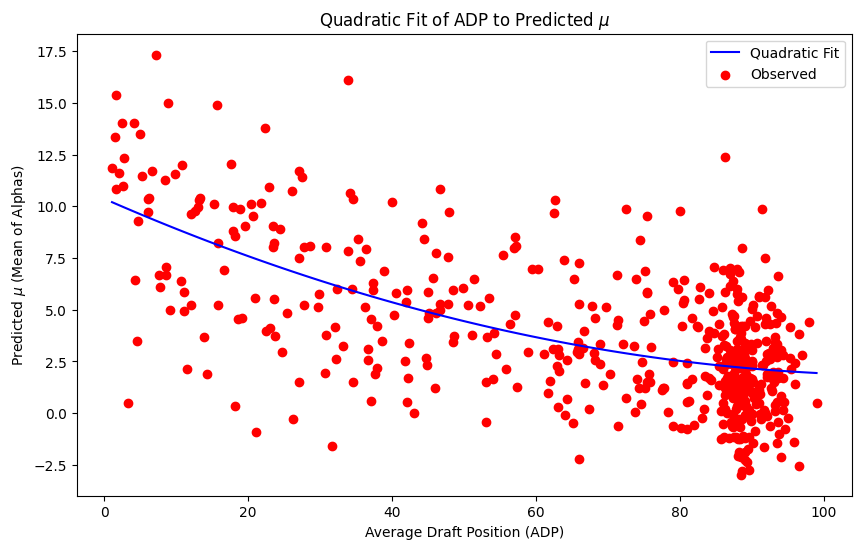

In [38]:
beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

# Create a sequence of ADP values for the plot
adp_values = np.linspace(min(stan_data['adp']), max(stan_data['adp']), 100)

# Calculate the predicted mu for each ADP value
predicted_mu = beta0_mean + beta1_mean * adp_values + beta2_mean * adp_values**2

# Extract the mean of alphas for each receiver
# Ensure the number of alpha means matches the number of unique player_year_ids
alpha_columns = [col for col in samples.columns if col.startswith('alpha.')]
alpha_means = samples[alpha_columns].mean(axis=0).values

# Plot ADP vs predicted mu
plt.figure(figsize=(10, 6))
plt.plot(adp_values, predicted_mu, label='Quadratic Fit', color='blue')
plt.scatter(stan_data['adp'], alpha_means, color='red', label='Observed')

# Add labels and title
plt.xlabel('Average Draft Position (ADP)')
plt.ylabel('Predicted $\mu$ (Mean of Alphas)')
plt.title('Quadratic Fit of ADP to Predicted $\mu$')
plt.legend()

# Show the plot
plt.show()

Building...



Building: 47.4s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1010)
Sampling:  10% (100/1010)
Sampling:  20% (200/1010)
Sampling:  30% (300/1010)
Sampling:  40% (400/1010)
Sampling:  50% (500/1010)
Sampling:  59% (600/1010)
Sampling:  69% (700/1010)
Sampling:  79% (800/1010)
Sampling:  89% (900/1010)
Sampling:  99% (1000/1010)
Sampling:  99% (1001/1010)
Sampling: 100% (1010/1010)
Sampling: 100% (1010/1010), done.
Messages received during sampling:
  Gradient evaluation took 0.001327 seconds
  1000 transitions using 10 leapfrog steps per transition would take 13.27 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_t7g2j9yh/model_kju5mzwt.stan', line 29, column 4 to

<stan.Fit>
Parameters:
    alpha: (533,)
    beta0: ()
    beta1: ()
    beta2: ()
    sigma: ()
    tau: ()
    mu: (533,)
Draws: 10
Posterior means of beta coefficients: beta0 = 14.587903706370733, beta1 = -0.16233736794523373, beta2 = 0.0005178968788219268


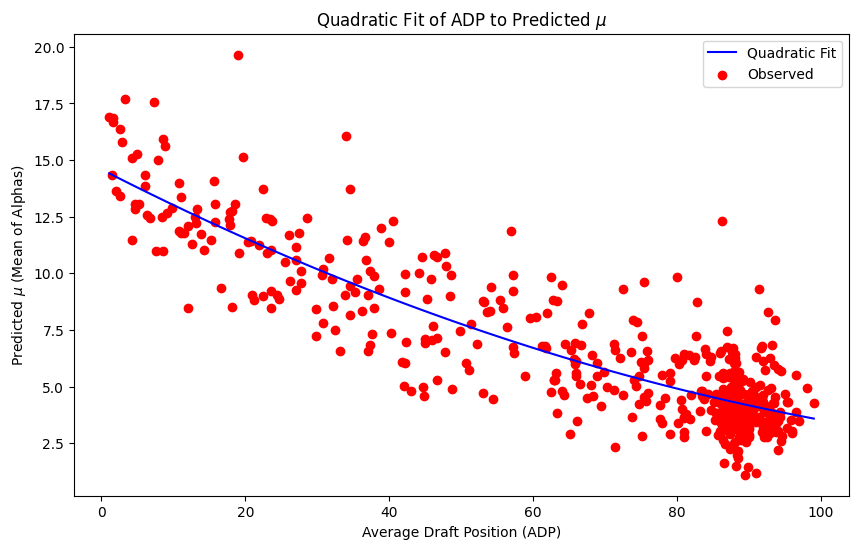

In [55]:
stan_model_code = """
data {
  int<lower=0> N;  // number of player-weeks
  int<lower=0> K;  // number of player-seasons
  array[N] int<lower=1, upper=K> receiver;  // receiver index for each data point
  vector[N] weekly_score;  // weekly scoring data
  vector[K] adp;  // average draft position for each receiver
}

parameters {
  vector<lower=0>[K] alpha;  // individual means for each receiver
  real beta0;  // intercept for the quadratic model
  real beta1;  // linear coefficient for the quadratic model
  real beta2;  // quadratic coefficient for the quadratic model
  real<lower=0> sigma;  // standard deviation of the weekly scores
  real<lower=0> tau;  // standard deviation of the alpha's
}

transformed parameters {
  vector[K] mu; // overall mean of alphas
  for (k in 1:K) {
    mu[k] = beta0 + beta1 * adp[k] + beta2 * adp[k] * adp[k];
  }
}

model {
  // likelihood
  for (n in 1:N) {
    weekly_score[n] ~ normal(alpha[receiver[n]], sigma);
  }
  //
  alpha ~ normal(mu, tau);

  // Prior distributions
  beta0 ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  tau ~ normal(0, 10);
  sigma ~ normal(0, 10);
}
"""
def prepare_stan_data(df):
    # Ensure the player_year_id column is unique per player and season
    df['receiver_index'] = df['player_year_id'].astype('category').cat.codes + 1
    N = df.shape[0]
    K = df['receiver_index'].nunique()
    receiver = df['receiver_index'].values
    weekly_score = df['fantasy_points_half_ppr'].values
    adp = df.drop_duplicates(subset=['player_year_id'])[['receiver_index', 'avg_draft_position']].sort_values('receiver_index')['avg_draft_position'].values

    stan_data = {
        'N': N,
        'K': K,
        'receiver': receiver.tolist(),
        'weekly_score': weekly_score.tolist(),
        'adp': adp.tolist()
    }

    return stan_data

# Prepare the data
stan_data = prepare_stan_data(merged_data)

# Compile the Stan model
stan_model = stan.build(stan_model_code, data=stan_data)

# Fit the Stan model
fit = stan_model.sample(num_chains=1, num_samples=10)
#fit = stan_model.sample(num_chains=4, num_samples=2000)

# Print the summary of the fit
print(fit)

# Extract the samples for further analysis
samples = fit.to_frame()

# For example, to get the posterior means of beta coefficients
beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

print(f'Posterior means of beta coefficients: beta0 = {beta0_mean}, beta1 = {beta1_mean}, beta2 = {beta2_mean}')

beta0_mean = samples['beta0'].mean()
beta1_mean = samples['beta1'].mean()
beta2_mean = samples['beta2'].mean()

# Create a sequence of ADP values for the plot
adp_values = np.linspace(min(stan_data['adp']), max(stan_data['adp']), 100)

# Calculate the predicted mu for each ADP value
predicted_mu = beta0_mean + beta1_mean * adp_values + beta2_mean * adp_values**2

# Extract the mean of alphas for each receiver
# Ensure the number of alpha means matches the number of unique player_year_ids
alpha_columns = [col for col in samples.columns if col.startswith('alpha.')]
alpha_means = samples[alpha_columns].mean(axis=0).values

# Plot ADP vs predicted mu
plt.figure(figsize=(10, 6))
plt.plot(adp_values, predicted_mu, label='Quadratic Fit', color='blue')
plt.scatter(stan_data['adp'], alpha_means, color='red', label='Observed')

# Add labels and title
plt.xlabel('Average Draft Position (ADP)')
plt.ylabel('Predicted $\mu$ (Mean of Alphas)')
plt.title('Quadratic Fit of ADP to Predicted $\mu$')
plt.legend()

# Show the plot
plt.show()

In [57]:
samples[['beta0', 'beta1', 'beta2', 'sigma', 'tau']].describe()

parameters,beta0,beta1,beta2,sigma,tau
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,14.587904,-0.162337,0.000518,5.617141,2.042034
std,0.424194,0.019095,0.000173,0.055129,0.089735
min,13.941678,-0.195606,0.000244,5.540320,1.937090
25%,14.323297,-0.167679,0.000408,5.570451,1.988477
50%,14.516251,-0.162825,0.000541,5.617310,2.029386
75%,14.748644,-0.153395,0.000577,5.650954,2.042401
max,15.339626,-0.129323,0.000832,5.707423,2.199452
